In [1]:
import sys
sys.path.insert(0, '..')
sys.path.insert(0, './src')

import seaborn as sns
import pandas as pd
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, leaves_list

from matplotlib_venn import venn3

from src.train import *
from src.functions import *
from src.plots import *
from src.dataset import *
from src.multixgboost import *

# Data exploration and visualizations

Firts let's define some color palettes for our plots to retain a similar visual identity.


In [29]:
df_cog, targets = load_cognition()
df_mri = load_brain_imaging()
df_counts, df_dge = load_transcriptomics()
df_csf = load_CSF()
df_gene =  load_apoe()

/home/chris/Documents/CHUV/PhD_project/Optimus/optimus/notebooks/../src/dataset.py:17: DtypeWarning: Columns (27,111) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv("../../../dataset/ADNI/ALL_3.csv").replace({"sc":"bl","Female":0, "Male":1})
/home/chris/Documents/CHUV/PhD_project/Optimus/optimus/notebooks/../src/dataset.py:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_all = pd.read_csv("../../../dataset/ADNI/ALL_3.csv").replace({"sc":"bl","Female":0, "Male":1})


In [17]:
df_cog.RID
df_mri.PTID
df_mri.RID
df_counts.rename({"SubjectID": "PTID"}, axis=1, inplace=True)
df_csf.PTID

0       011_S_0003
1       011_S_0003
2       022_S_0004
3       022_S_0004
4       011_S_0005
           ...    
3169    131_S_7032
3170    941_S_7041
3171    129_S_7042
3172    033_S_7066
3173    035_S_7073
Name: PTID, Length: 3262, dtype: object

In [18]:
def merge_all_on_mri(df_mri, df_cog, df_counts, df_csf):
    # Ensure consistent column names
    df_counts = df_counts.rename(columns={"SubjectID": "PTID"})

    # Step 1: Make sure df_mri has RID — if not, fallback to PTID
    merge_key = "RID" if "RID" in df_mri.columns else "PTID"

    # Step 2: Start with df_mri
    df_merged = df_mri.copy()

    # Step 3: Merge with df_cog on RID
    if "RID" in df_cog.columns and "RID" in df_mri.columns:
        df_merged = df_merged.merge(df_cog, on=["RID", "VISCODE"], how="left")
    else:
        df_merged = df_merged.merge(df_cog, on=["PTID", "VISCODE"], how="left")

    # Step 4: Merge with df_counts on PTID + VISCODE
    df_merged = df_merged.merge(df_counts, on=["PTID", "VISCODE"], how="left")

    # Step 5: Merge with df_csf on PTID + VISCODE
    df_merged = df_merged.merge(df_csf, on=["PTID", "VISCODE"], how="left")

    return df_merged


In [ ]:
df_all = merge_all_on_mri(df_mri, df_cog, df_counts, df_csf, df_dg)

In [23]:
print(df_all.isna().sum())

Orig/Proc            0
SubjectID            0
Visit                0
MagStrength          0
Sequence             0
                  ... 
AB4240            7592
NOTE              7592
ABETA40           7505
COMMENT           7444
update_stamp_y    6610
Length: 232, dtype: int64


In [24]:
df_mri.AGE.isna().sum()

0

In [25]:
df_mri.PTEDUCAT.isna().sum()

0

## Load data

In [2]:
def load_pickle_data_palettes(drop_pet=True):
    # Define file paths
    file_paths = {
        "df_X": "df_X_original.pickle",
        "df_y": "df_y_original.pickle",
        "df_all": "df_all_original.pickle",
        "df_FinalCombination": "df_all.pickle",
        "dict_select": "select_features.pickle",
        "miss_mask": "filter_miss_mask.pickle"
    }

    # Load all pickle files
    data = {key: pd.read_pickle(f"../pickle/{path}") for key, path in file_paths.items()}
    
    # Convert miss_mask to list
    data["miss_mask"] = data["miss_mask"].tolist()

    # Extract selected features
    feature_keys = ["RNA", "CSF", "DNA", "MRIth", "MRIvol", "PET"]
    select_features = [data["dict_select"][key] for key in feature_keys]
    data["df_select_features"] = pd.DataFrame(select_features).T
    
    # Define colormaps
    full_palette = {
        "orange": "#ff4b41", "yellow": "#ffaa41", "blue": "#75d8ff", 
        "cyan": "#d7d341", "purple": "#e59edd", "green": "#70d941"
    }
    
    data["colormaps"] = {
        "full_palette": full_palette,
        "gender_palette": {"0": full_palette["green"], "1": full_palette["purple"]},
        "dx_palette": {"CN": "#75d8ff", "MCI": "#ffcc92", "AD": "#ff4b41"}
    }

    if drop_pet: 
        data["df_X"] = data["df_X"][[col for col in data["df_X"].columns if not re.search(r'PET$|GM', col)]]

    return data

In [27]:
data = load_pickle_data_palettes(drop_pet=False)

# Unpack data
df_X, df_y, df_all, df_FinalCombination = data["df_X"], data["df_y"], data["df_all"], data["df_FinalCombination"]
df_select_features, miss_mask = data["df_select_features"], data["miss_mask"]

# Unpack feature selections
select_RNA, select_CSF, select_gene, select_MRIthickness, select_MRIvolume, select_PET = df_select_features.T.values

# Unpack colormaps
full_palette, gender_palette, dx_palette = data["colormaps"].values()

# Missing valus and repeated measurements

In [26]:
notna_counts = df_X.notna().sum()
notna_groups = notna_counts.groupby(notna_counts).apply(lambda x: list(x.index))
notna_summary_df = pd.DataFrame({'Available mesurements percentage [%]': notna_groups.index/(df_X.shape[0])*100, 'Columns': notna_groups.values})
notna_summary_df["Modality"] = ["PET", "GM", "TAU_PTAU", "ABETA", "APOE2_3", "RNA", "Cortical", "APOE4"]
notna_summary_df = notna_summary_df.drop(1)
notna_summary_df.reset_index(drop=True).sort_values("Available mesurements percentage [%]", ascending=False)

NameError: name 'df_X' is not defined

/tmp/ipykernel_102495/1754462656.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(notna_summary_df.drop(2).reset_index(drop=True).sort_values("Available mesurements percentage [%]", ascending=False)[:-1],
/tmp/ipykernel_102495/1754462656.py:4: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  ax = sns.barplot(notna_summary_df.drop(2).reset_index(drop=True).sort_values("Available mesurements percentage [%]", ascending=False)[:-1],
/tmp/ipykernel_102495/1754462656.py:4: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  ax = sns.barplot(notna_summary_df.drop(2).reset_index(drop=True).sort_values("Available mesurements percentage [%]", ascending=False)[:-1],
/tmp/ipykernel_102495/1754462656.py:12: Us

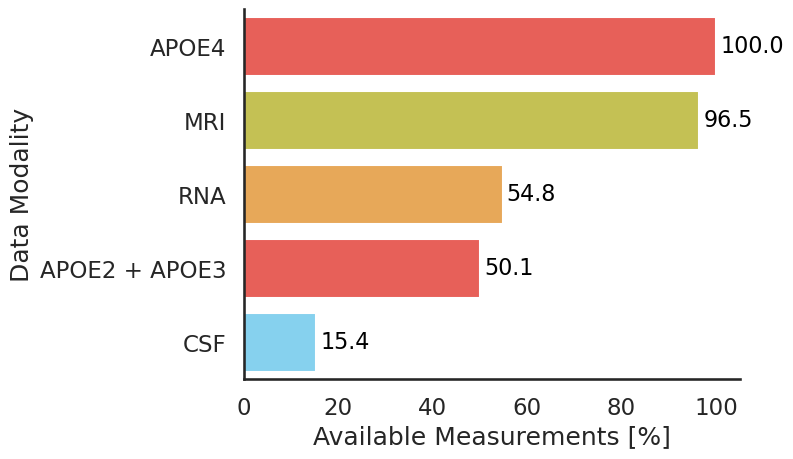

In [5]:
sns.set_style("white")
sns.set_context("talk") 

ax = sns.barplot(notna_summary_df.drop(2).reset_index(drop=True).sort_values("Available mesurements percentage [%]", ascending=False)[:-1], 
                 y="Modality", x='Available mesurements percentage [%]', 
                palette=np.array(list(full_palette.values()))[[0, 3, 1, 0, 2, 4]])
sns.despine()

# Customize axis labels
ax.set_xlabel("Available Measurements [%]")
ax.set_ylabel("Data Modality")
ax.set_yticklabels([label.get_text().replace("ABETA","CSF").replace("APOE2_3","APOE2 + APOE3").replace('_', ' + ').replace("Cortical","MRI")  for label in ax.get_yticklabels()])

i = 0
for i, container in enumerate(ax.containers):
    if i < 7:
        ax.bar_label(container, labels=[f"{x:.1f}" for x in container.datavalues], label_type='edge',padding=3, fontsize=16, color='black')

plt.savefig("../figures/data_availability.png", format="png", bbox_inches='tight')

### Plot number of time points

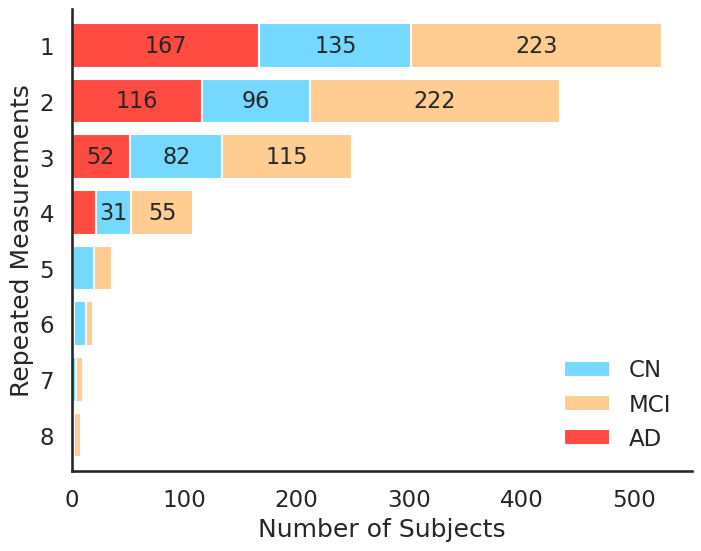

In [8]:
# Set Seaborn style
sns.set_style("white")
sns.set_context("talk")

order = ['CN', 'MCI', 'AD']

# Step 1: Group data
rid_counts = df_all.groupby(['DX', 'RID']).size().reset_index(name='measurement_count')

# Step 2: Count occurrences of each measurement count within each DX category
measurement_counts = rid_counts.groupby(['measurement_count', 'DX']).size().unstack(fill_value=0)

# Step 3: Sort the index in descending order to reverse the y-axis
measurement_counts = measurement_counts.sort_index(ascending=False)

# Step 4: Plot the stacked bar plot transposed (horizontal bars) with reversed y-axis
fig, ax = plt.subplots(figsize=(8, 6))
measurement_counts.plot(kind='barh', stacked=True, width=0.8, ax=ax, color=dx_palette,)

# Step 5: Add count labels for the first 3 bars only, and display as integers
threshold = 30
for c in ax.containers:
    # Format labels as integers
    labels = [int(v) if v > threshold else "" for v in c.datavalues]    
    ax.bar_label(c, labels=labels, label_type="center", fontsize=16,)

# Customizing the plot
plt.ylabel("Repeated Measurements")
plt.xlabel("Number of Subjects")

# Reorder the legend to CN, MCI, AD
handles, labels = ax.get_legend_handles_labels()

handles = [handles[labels.index(order_item)] for order_item in order]
labels = order
ax.legend(handles=handles, labels=labels, loc='lower right', frameon=False)

sns.despine(left=False, bottom=False)

# Show plot
plt.savefig("../figures/data_exploration_longitudinal.png", bbox_inches='tight', format="png")

# Plot demographic variables

In [9]:
select = pd.read_pickle('../pickle/select_features.pickle')

# Ensure to remove samples with too many missing values as fefined in the miss_mask
miss_mask = pd.read_pickle('../pickle/filter_miss_mask.pickle')
miss_mask = miss_mask.tolist()

df_all = df_all[miss_mask]

## Plot sex

/tmp/ipykernel_28302/2014214146.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_demo.PTGENDER = df_all_demo.PTGENDER.apply(lambda x : str(int(x)))


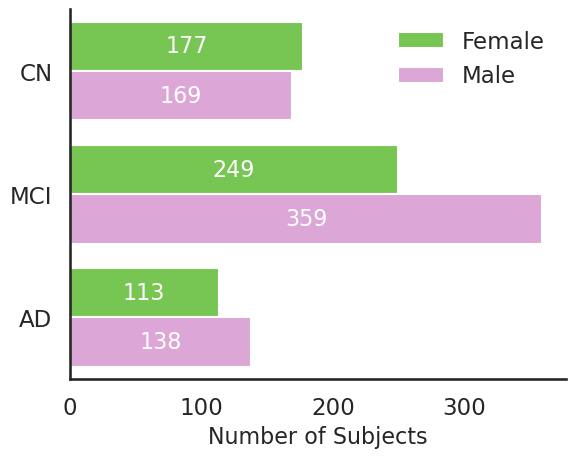

In [10]:
df_all_demo = df_all.drop_duplicates(subset="RID")
dict_gender = {"Female":"0", "Male":"1"}
dict_gender = dict((v, k) for k, v in dict_gender.items())
df_all_demo.PTGENDER = df_all_demo.PTGENDER.apply(lambda x : str(int(x)))

# Plot
ax = sns.countplot(df_all_demo, y="DX", hue="PTGENDER", palette=gender_palette, order=["CN", "MCI", "AD"], hue_order=["0", "1"])

# Remove the top and right spines
sns.despine()

# Add count labels
i = 0
for container in ax.containers:
    if i < 5: 
        ax.bar_label(container, label_type='center', fontsize=16, color='white')

# Update the legend
handles, labels = ax.get_legend_handles_labels()
new_labels = ['Female', 'Male']  # Replace 0 with F and 1 with M
ax.legend(handles=handles, labels=new_labels, loc='upper right', frameon=False)

ax.set_xlabel("Number of Subjects", fontsize=16)
ax.set_ylabel(None)

# Save the plot
plt.savefig("../figures/data_gender_group.png", bbox_inches='tight', format="png")

## Plot APOE groups

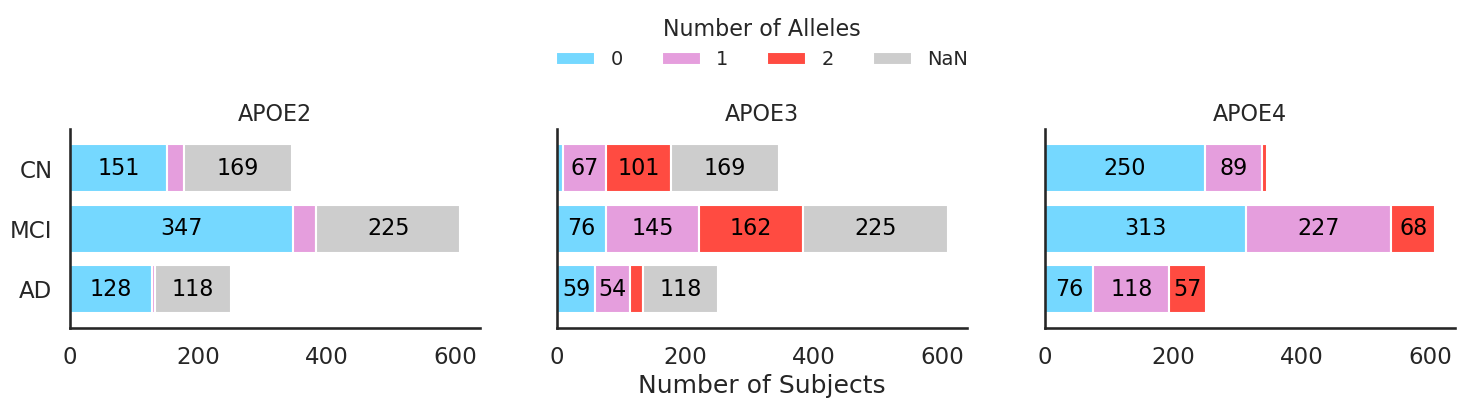

In [11]:
# Step 1: Count occurrences of each genotype level for each diagnostic group, including NaN values
df_melted = df_all_demo.melt(
    id_vars='DX', 
    value_vars=['APOE_epsilon2', 'APOE_epsilon3', 'APOE_epsilon4'], 
    var_name='Genotype', value_name='Level'
)

# Fill NaN values with a specific label (e.g., "NaN") to ensure they are counted
df_melted['Level'] = df_melted['Level'].fillna('NaN')

# Group by DX, Genotype, and Level, then count occurrences
genotype_counts = df_melted.groupby(['DX', 'Genotype', 'Level']).size().unstack(fill_value=0)

# Step 2: Plot each genotype separately with horizontal stacked bars, including NaN counts
fig, axes = plt.subplots(1, 3, figsize=(15, 6), sharey=True)
genotypes = ['APOE_epsilon2', 'APOE_epsilon3', 'APOE_epsilon4']
threshold = 40  # Only show labels for values above this threshold

for i, genotype in enumerate(genotypes):
    ax = axes[i]
    
    # Extract counts for the current genotype across all diagnostic groups
    counts = genotype_counts.xs(genotype, level='Genotype').loc[order[::-1]]
    counts.plot(kind='barh', stacked=True, ax=ax,
                color=[full_palette["blue"], full_palette["purple"], full_palette["orange"], "#cdcdcd"], width=0.8)

    # Add count labels only if they exceed the threshold
    for container in ax.containers:
        labels = [f"{int(v)}" if v > threshold else "" for v in container.datavalues]
        ax.bar_label(container, labels=labels, label_type='center', fontsize=16, color='black')

    # Set title and labels
    ax.set_title(genotype.replace("_epsilon", ""), fontsize=16)
    ax.set_xlabel("Number of Subjects" if i == 1 else "")
    ax.set_ylabel(None)

    # Remove legend from the first two plots
    if i !=1:
        ax.get_legend().remove()

# Move the legend outside the third plot
# Convert legend text to integers, ignoring NaN values
handles, labels = axes[1].get_legend_handles_labels()
labels = [str(int(float(label))) if label.replace('.', '', 1).isdigit() else label for label in labels]

legend = axes[1].legend(
    handles, labels,
    title="Number of Alleles",
    bbox_to_anchor=(0.5, 1.6),
    loc='upper center',
    ncol=len(labels),    
    borderaxespad=0,
    frameon=False,
    fontsize=14
)
plt.setp(legend.get_title(), fontsize=16)

# Adjust layout and remove unnecessary spines
plt.tight_layout()
sns.despine()

# Save the plot
plt.savefig("../figures/data_genotypes.png",bbox_inches='tight', format="png")


## Plot AGE

/tmp/ipykernel_28302/903817936.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all['Age Group'] = pd.cut(df_all_demo['AGE'], bins=age_bins, labels=age_labels, right=False)
/tmp/ipykernel_28302/903817936.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_demo["Age Group"] = df_all['Age Group']
/home/chris/miniforge3/envs/optimus/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 20.3% of the points cannot be placed; you may want to decrease the size of the markers or use st

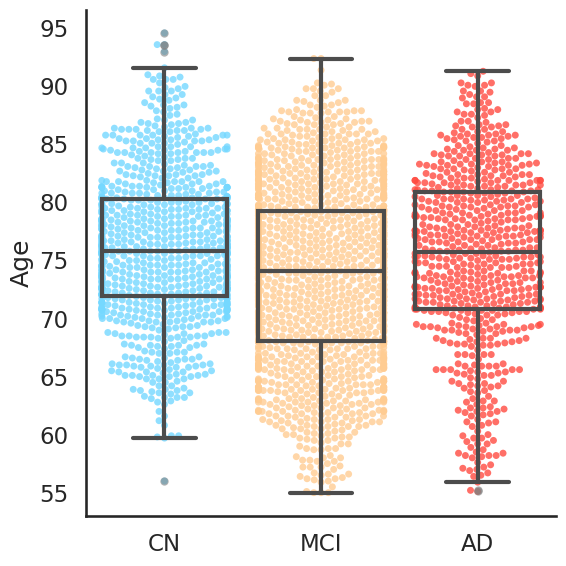

In [12]:
# Step 1: Define age groups
age_bins = [0, 60, 70, 80, 90, float("inf")]
age_labels = ["<60", "60-70", "70-80", "80-90", "90+"]
df_all['Age Group'] = pd.cut(df_all_demo['AGE'], bins=age_bins, labels=age_labels, right=False)

df_all_demo["Age Group"] = df_all['Age Group']

# Step 2: Plot boxplot and swarmplot with ordered x-axis
# Set Seaborn style
sns.set_style("white")
sns.set_context("talk")

# Initialize Figure and Axes object
fig, ax = plt.subplots(figsize=(6,6))

# Swarmplot with aligned positions
sns.swarmplot(
    y='AGE', x='DX', data=df_all, hue='DX', palette=dx_palette, order=["CN", "MCI", "AD"],
    alpha=0.8, zorder=1, ax = ax
)

# Boxplot with black outlines and grey outliers
sns.boxplot(
    y='AGE', x='DX', data=df_all, order=["CN", "MCI", "AD"],
      linewidth=3,
      boxprops={'facecolor':'None'},
      ax=ax, flierprops=dict(marker='o', markersize=6, markeredgewidth=0, markerfacecolor='grey', markeredgecolor='grey', alpha=0.6)
)

# Customize axis labels and legend
ax.set_ylabel("Age")
ax.set_xlabel("")

sns.despine()

# Adjust layout and save as PNG
plt.tight_layout()
plt.savefig("../figures/data_age_boxplots_enrolment.png",bbox_inches='tight', format="png")

## Plot Education years

/tmp/ipykernel_28302/2710974963.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_demo['Education Group'] = pd.cut(df_all['PTEDUCAT'], bins=education_bins, labels=education_labels, right=False)


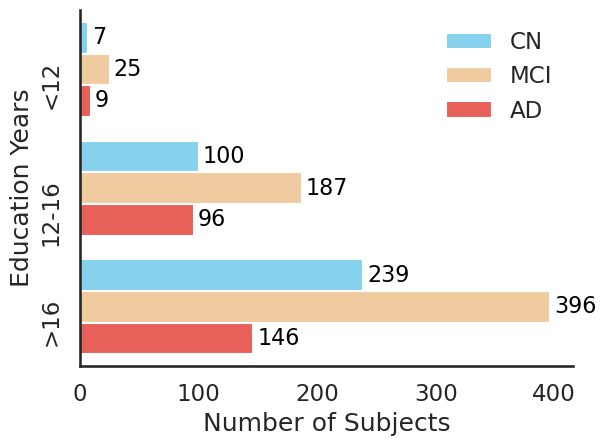

In [13]:
# Assume df_all is your DataFrame with the columns 'PTEDUCAT' and 'DX'
sns.set_style("white")
sns.set_context("talk")
# Step 1: Bin the education years (PTEDUCAT) into the specified categories
education_bins = [0, 12, 16, float('inf')]  # Bins: <12, 12-16, >16
education_labels = ["<12", "12-16", ">16"]  # Labels for the bins

# Create a new column 'Education Group' based on the bins
df_all_demo['Education Group'] = pd.cut(df_all['PTEDUCAT'], bins=education_bins, labels=education_labels, right=False)

# Step 2: Plot a horizontal countplot for education groups, colored by DX
ax = sns.countplot(y='Education Group', hue='DX', data=df_all_demo, palette=dx_palette, hue_order=order)#order=order)
sns.despine()

i = 0
for container in ax.containers:
    if i < 5: 
        ax.bar_label(container, label_type='edge', padding=3, fontsize=16, color='black')

# Customize plot
plt.xlabel("Number of Subjects")
plt.ylabel("Education Years")

plt.yticks(rotation=90)

# Reorder the legend to CN, MCI, AD
handles, labels = ax.get_legend_handles_labels()
order = ['CN', 'MCI', 'AD']
handles = [handles[labels.index(order_item)] for order_item in order]
labels = order
ax.legend(handles=handles, labels=labels, title=None, loc='upper right', frameon=False)

# Display the plot
plt.tight_layout()
plt.savefig("../figures/data_education_years.png",bbox_inches='tight', format="png")

# Plot targets

/tmp/ipykernel_28302/4253236954.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([label_dict.get(label.get_text(), label.get_text()) for label in ax.get_xticklabels()], rotation=45)


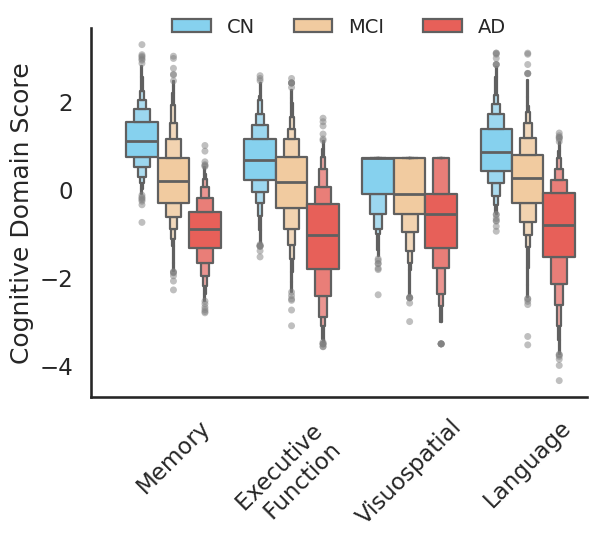

In [14]:
# Set Seaborn style
sns.set_style("white")
sns.set_context("talk")
# Create the boxenplot
ax = sns.boxenplot(pd.concat([df_y, df_all[["DX"]]], axis=1).melt(id_vars=["DX"]),
                   x="variable", y="value", hue="DX", palette=dx_palette, hue_order=["CN", "MCI", "AD"],
                   flier_kws=dict(marker='o', color='grey', alpha=0.5, facecolor="grey", edgecolor='none'),
                   linewidth=1.6)  # Customize outliers

# Step 1: Change the x-axis labels by setting them manually
label_dict = {
    "ADNI_MEM": "Memory",
    "ADNI_EF": "Executive \n Function",  # Added \n for the line break
    "ADNI_VS": "Visuospatial",
    "ADNI_LAN": "Language"
}

# Set x-tick labels from the label_dict
ax.set_xticklabels([label_dict.get(label.get_text(), label.get_text()) for label in ax.get_xticklabels()], rotation=45)

# Step 2: Move the legend outside, to the left and centered
handles, labels = ax.get_legend_handles_labels()

legend = ax.legend(
    handles, labels,
    title=None,
    bbox_to_anchor=(0.5, 1.05),
    ncol=len(labels),    
    loc='upper center',   
    borderaxespad=0,
    fontsize=14,
    frameon=False
)
plt.setp(legend.get_title(), fontsize=16)
# Or adjust y-axis limits for horizontal boxplots
plt.gca().set_xlim(left=plt.gca().get_xlim()[0] - 0.2) 

# Step 3: Set the y-axis label
plt.ylabel("Cognitive Domain Score")
plt.xlabel("")  # This will remove the x-axis label

# Remove top and right spines
sns.despine()

# Step 5: Save the figure
plt.savefig("../figures/boxenplot_targets.png", bbox_inches='tight', format="png")

## Correlation between targets

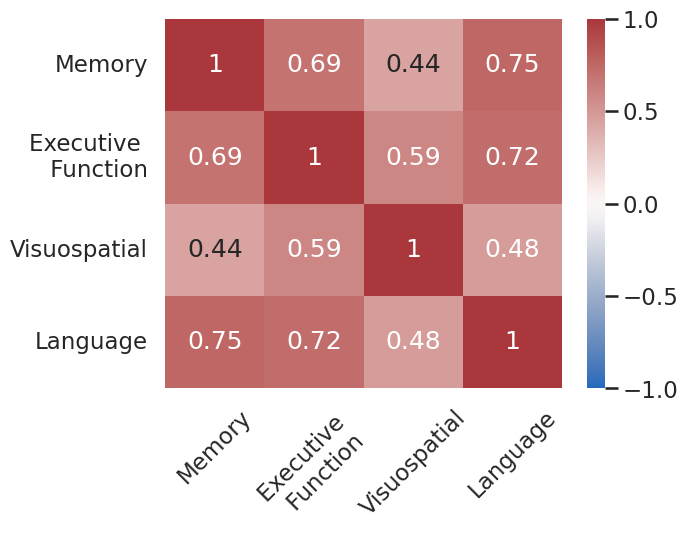

In [15]:
# Mapping the current column names to more readable names
label_map = {
    "ADNI_MEM": "Memory",
    "ADNI_EF": "Executive \n Function",
    "ADNI_VS": "Visuospatial",
    "ADNI_LAN": "Language"
}

# Rename the columns in df_y using the label_map
df_y_renamed = df_y.rename(columns=label_map)

# Plotting the heatmap
sns.set(style="whitegrid", context="talk")
sns.heatmap(df_y_renamed.corr(), cmap="vlag", annot=True, vmax=1, vmin=-1, cbar_kws=dict(ticks=[1, .5, 0, -0.5, -1]))
plt.xticks(rotation=45)
# Save the figure
plt.savefig("../figures/cognitive_target_correlation.png", bbox_inches='tight',  format="png")

# Plot features

## Plot CSF

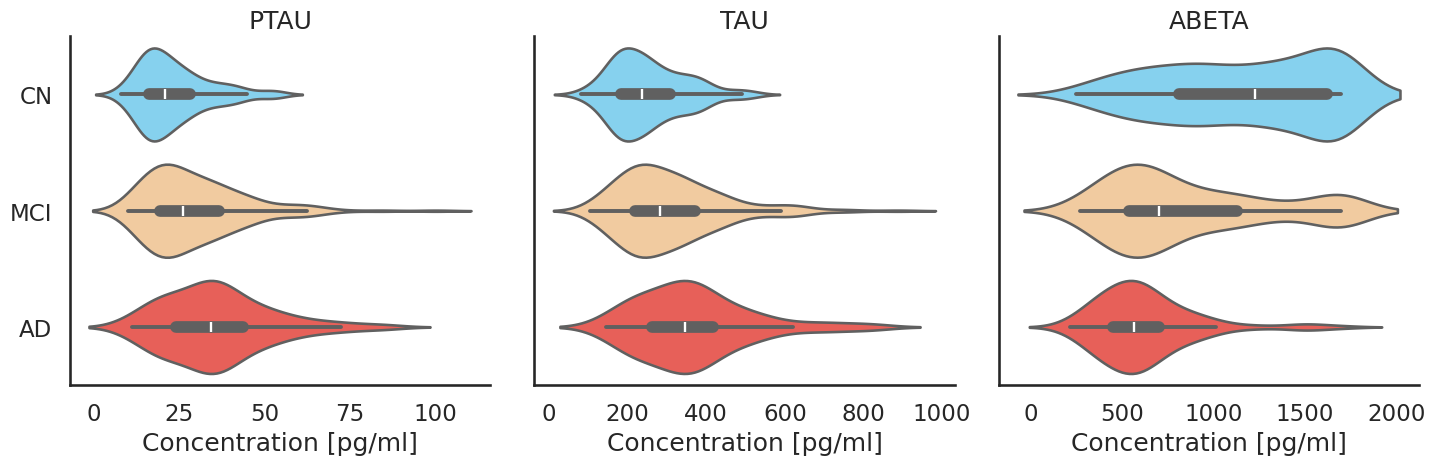

In [16]:
#Create the violin plot
sns.set_style("white")
sns.set_context("talk")

g = sns.catplot(
    data=df_FinalCombination[["PTAU", "TAU", "ABETA", "DX"]].melt(id_vars="DX", var_name="CSF protein", value_name="Concentration"),
    y="DX", x="Concentration", col="CSF protein", kind="violin", hue="DX",
    order=order,
    sharex=False, sharey=True, palette=dx_palette #, order=["CN", "MCI", "AD"]
)

# Remove the "CSF protein =" part from the titles
g.set_titles("{col_name}")
# Change the x and y axis titles
g.set_axis_labels("Concentration [pg/ml]", "")

# Remove top and right spines
sns.despine()

# Save the plot as PNG
plt.savefig("../figures/violinplot_csf.png", format="png", bbox_inches='tight')

# Show the plot
plt.show()

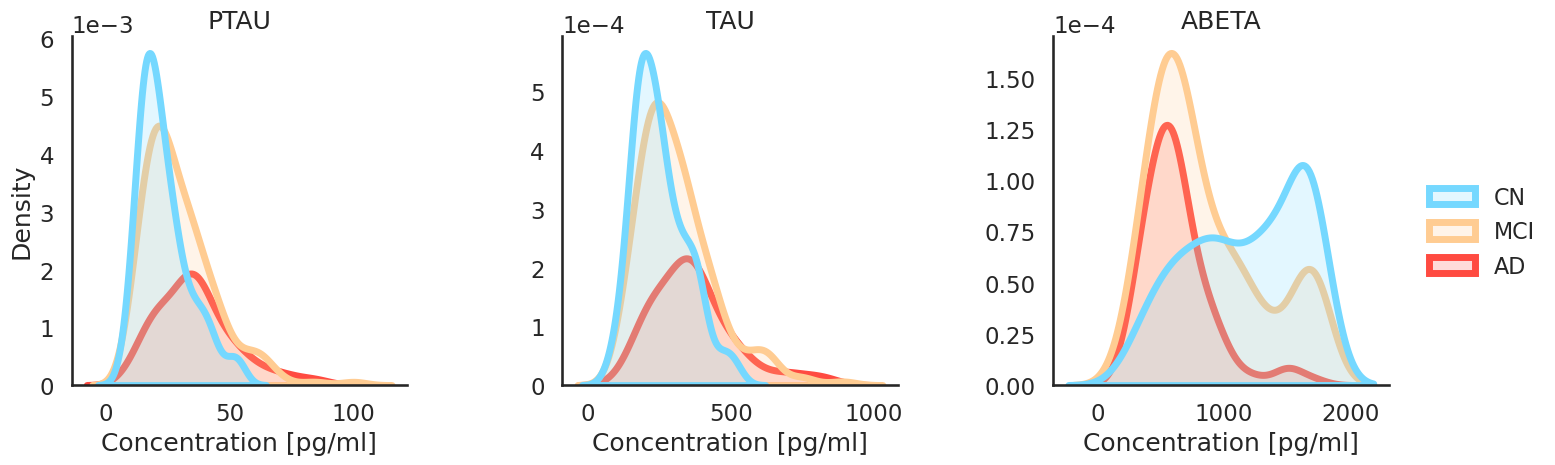

In [17]:
sns.set_style("white")
sns.set_context("talk")
                
g = sns.displot(data=df_FinalCombination[["PTAU", "TAU", "ABETA", "DX"]].melt(id_vars="DX", var_name="CSF protein", value_name="Concentration [pg/ml]"), 
                x="Concentration [pg/ml]", col="CSF protein", kind="kde", 
                hue="DX", palette=dx_palette, 
                hue_order=["CN", "MCI", "AD"], 
                linewidth=5, fill=True, alpha=0.2,
                facet_kws=dict(sharex=False, sharey=False))

for axes in g.axes.flat:
    axes.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))

# Remove the "CSF protein =" part from the titles
g.set_titles("{col_name}")

# Customize legend text size
for text in g._legend.get_texts():
    text.set_fontsize(16)

g._legend.set_title("")

sns.despine()
plt.savefig("../figures/distplots_csf.png", bbox_inches='tight', format="png")

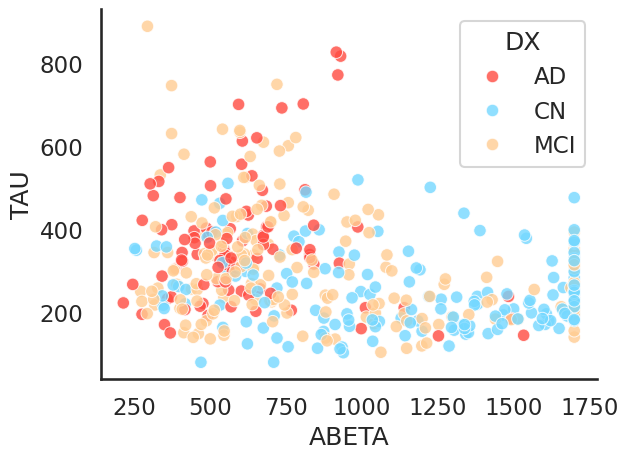

In [18]:
sns.scatterplot(df_FinalCombination,x="ABETA", y="TAU", hue="DX", palette=dx_palette, alpha = 0.8)
sns.despine()
#plt.savefig("../figures/scatter_csf.svg", bbox_inches='tight', format="svg")

## Plot MRI features per network

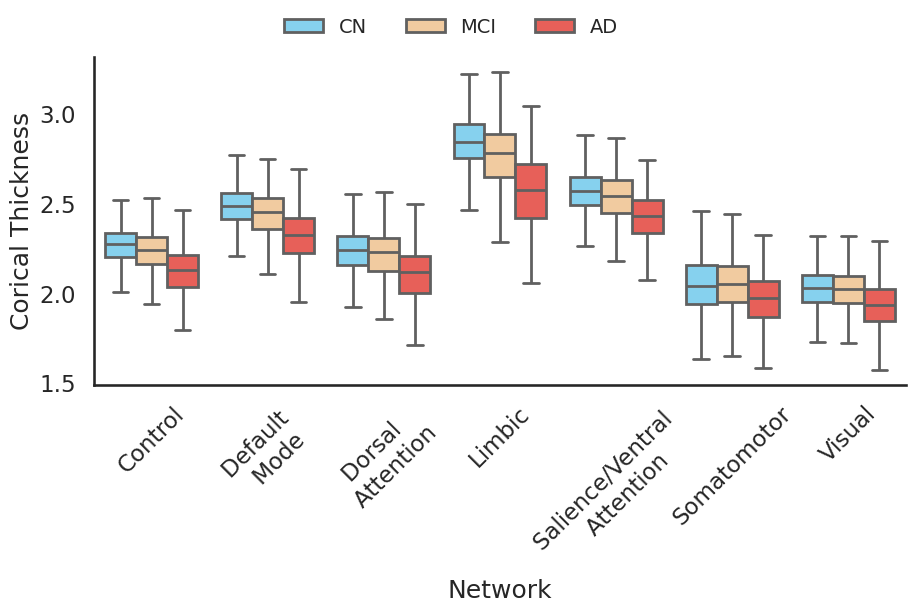

In [19]:
df_plt_MRI = df_X[select_MRIthickness].T.reset_index(names="ROI")
df_plt_MRI["Network"] = df_plt_MRI.ROI.apply(lambda x : x.split('_')[1])
df_plt_MRI = df_plt_MRI.iloc[:, 1:].groupby(by=['Network']).mean().T
df_plt_MRI = pd.concat([df_plt_MRI, df_all[["RID", "VISCODE", "Months", "DX"]]], axis=1)
df_plt_MRI = pd.melt(df_plt_MRI, id_vars = ['RID', 'VISCODE', 'Months', 'DX'], value_vars=['Cont', 'Default', 'DorsAttn', 'Limbic', 'SalVentAttn', 'SomMot', 'Vis'], var_name="Network", value_name="Corical Thickness")
df_plt_MRI = df_plt_MRI.dropna(axis=0)

# Define the network full names
network_names = {
    "Cont": "Control",
    "Default": "Default \n Mode",
    "DorsAttn": "Dorsal \n Attention",
    "Limbic": "Limbic",
    "SalVentAttn": "Salience/Ventral \n Attention",
    "SomMot": "Somatomotor",
    "Vis": "Visual"
}

# Replace the variable names with full network names
df_plt_MRI["Network"] = df_plt_MRI["Network"].replace(network_names)

# Set Seaborn style
sns.set_style("white")
sns.set_context("talk")

# Create the plot
g = sns.catplot(
    data=df_plt_MRI, x="Network", y="Corical Thickness", hue="DX",
    kind="box", palette=dx_palette, showfliers=False, height=6, aspect=1.4, hue_order=["CN", "MCI", "AD"],
    linewidth=2,  # Thicker boxplot lines
    flierprops=dict(marker='o', color='grey', alpha=0.5, markerfacecolor='grey', markeredgecolor=None, markersize=6)  # Outlier style
)

# Remove the default legend
g._legend.remove()

# Rotate x-axis labels for readability
plt.xticks(rotation=45)

# Add the custom legend at the top center
handles, labels = g.ax.get_legend_handles_labels()
fig = g.fig  # Access the figure from the Catplot object
fig.legend(
    handles, labels,
    loc='upper center',             # Place the legend at the top center
    bbox_to_anchor=(0.5, 1.05),    # Adjust position; (0.5, 1.05) centers it slightly above the figure
    ncol=len(labels),               # Display legend items in a single row
    frameon=False,                  # Remove legend border
    fontsize=14,                    # Font size for legend text
    title_fontsize=16,               # Font size for the legend title
)

# Adjust plot aesthetics
sns.despine()
plt.tight_layout()

# Save the figure
plt.savefig("../figures/boxplot_network_mri.png", format="png", bbox_inches="tight")

# Show the plot
plt.show()

## Transcriptomics

In [20]:
df_all_counts = pd.read_csv("../../../dataset/ADNI/gene_expression_microarray/filtered_counts.csv", index_col=0)
df_samples = pd.read_csv("../../../dataset/ADNI/gene_expression_microarray/filtered_samples.csv", index_col=0)
df_genes = pd.read_csv("../../../dataset/ADNI/gene_expression_microarray/filtered_genes.csv", index_col=0)
df_dge = pd.read_csv("../../../dataset/ADNI/gene_expression_microarray/dge_gene_selection.csv", index_col=0)

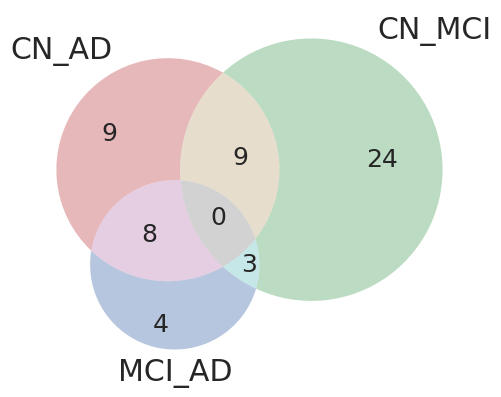

In [21]:
set1 = set(df_dge[df_dge.Test == "CN_AD"].Symbol.tolist())
set2 = set(df_dge[df_dge.Test == "CN_MCI"].Symbol.tolist())
set3 = set(df_dge[df_dge.Test == "MCI_AD"].Symbol.tolist())

venn3([set1, set2, set3], ('CN_AD', 'CN_MCI', 'MCI_AD'))

plt.show()

In [22]:
df_all_counts = df_all_counts.transpose()
df_all_counts = df_all_counts.merge(df_samples[["SubjectID", "Visit", "group"]], left_index=True, right_index=True)
df_all_counts = df_all_counts.reset_index(drop=True).drop_duplicates()
df_all_counts = df_all_counts.rename(columns={"Visit":"VISCODE"})

In [23]:
df_samples

,group,lib.size,norm.factors,Phase,Visit,SubjectID,X260.280,X260.230,RIN,Affy.Plate,...,PTTLANG,PTPLANG,PTPSPEC,PTCOGBEG,PTMCIBEG,PTADBEG,PTADDX,PTETHCAT,PTRACCAT,DXAGG
002_S_0413_m72,CN,82476.651,1,ADNIGO,m48,116_S_1249,2.05,0.55,7.7,7,...,1.0,1.0,-4,NaN,NaN,NaN,NaN,2.0,5.0,CN
002_S_0685_m48,CN,82484.664,1,ADNI2,bl,037_S_4410,2.07,1.54,7.6,3,...,1.0,1.0,-4,9999.0,NaN,NaN,9999.0,2.0,5.0,CN
002_S_0729_m48,AD,81808.151,1,ADNI2,bl,006_S_4153,2.04,2.10,7.2,6,...,1.0,1.0,-4,2007.0,NaN,NaN,2009.0,2.0,5.0,AD
002_S_1155_m48,CN,82468.697,1,ADNIGO,m48,116_S_1232,2.03,1.52,6.8,7,...,1.0,1.0,-4,NaN,NaN,NaN,NaN,2.0,5.0,CN
002_S_1261_m48,MCI,82186.068,1,ADNI2,bl,099_S_4205,2.01,1.60,7.9,9,...,1.0,1.0,-4,2007.0,NaN,NaN,9999.0,2.0,5.0,MCI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
941_S_4292_bl,MCI,82631.884,1,ADNIGO,bl,009_S_2381,1.87,1.45,6.6,8,...,1.0,1.0,-4,NaN,2009.0,NaN,NaN,2.0,5.0,MCI
941_S_4365_bl,MCI,82559.387,1,ADNI2,bl,053_S_4557,2.03,1.33,6.8,5,...,1.0,1.0,-4,2010.0,NaN,NaN,9999.0,2.0,5.0,MCI
941_S_4376_bl,MCI,82251.683,1,ADNI2,bl,073_S_4300,2.11,0.27,6.2,3,...,1.0,1.0,-4,2001.0,NaN,NaN,9999.0,2.0,5.0,MCI
941_S_4377_bl,CN,82957.701,1,ADNI2,bl,041_S_4014,1.94,1.72,5.8,1,...,1.0,1.0,-4,9999.0,NaN,NaN,9999.0,2.0,5.0,CN


0
CN
MCI
AD


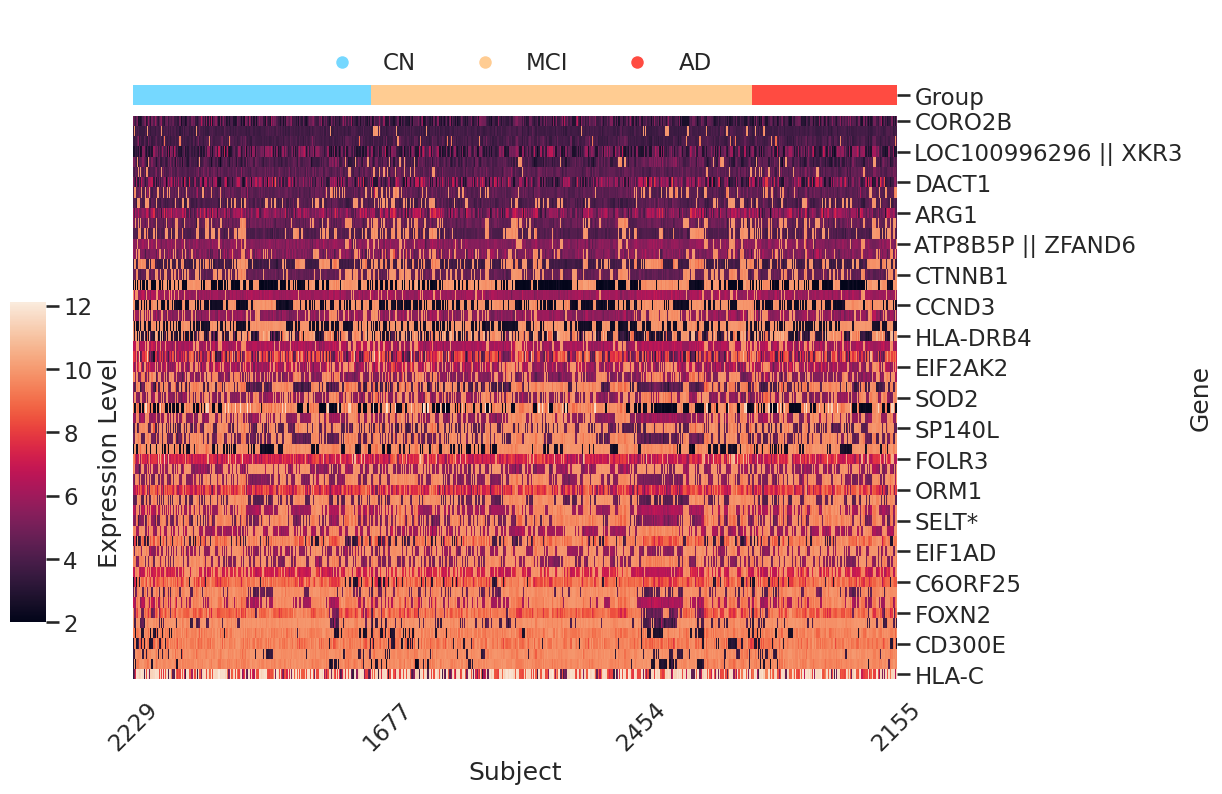

In [24]:
df_X_rna = pd.concat([df_X[list(set(select["RNA"]))].reset_index(drop=True), 
                      df_all[["RID", "DX"]].reset_index(drop=True)], axis=1).dropna().drop_duplicates().sort_values("RID").drop_duplicates(subset="RID")

custom_dict = {'CN': 0, 'MCI': 1, 'AD': 2}

df_X_rna = df_X_rna.sort_values("DX", key=lambda x: x.map(custom_dict))
print(df_X_rna.columns.has_duplicates or df_X_rna.RID.duplicated().sum())


ordered_subjects= []

sns.set(style="whitegrid", context="talk")

for dx in ["CN", "MCI", "AD"]: 
    print(dx)
    group_data = df_X_rna[df_X_rna.DX == dx]

    distance_matrix = pdist(group_data.drop(columns=["RID", "DX"]), metric="euclidean")  
    linkage_matrix = linkage(distance_matrix, method="centroid")  

    # Get the order of columns based on hierarchical clustering
    clustered_order = [group_data.index[i] for i in leaves_list(linkage_matrix)]
    
    # Add the clustered order to the list of ordered columns
    ordered_subjects.extend(clustered_order)

# Sort transcriptomics Subjects
df_X_rna = df_X_rna.reindex(ordered_subjects)

# Sort transcriptmics Genes
ordered_genes = df_dge.sort_values("logCPM").drop_duplicates("Symbol", keep="first").Symbol.tolist()
# ordered_genes = df_X_rna.drop(columns=["RID", "DX"]).mean().sort_values().index.tolist()

df_X_rna = df_X_rna.reindex(["RID", "DX"]+ordered_genes, axis=1)

dx_colors = df_X_rna["DX"].rename("Group").map(dx_palette)
df_X_rna_sorted = df_X_rna.drop(columns=["RID", "DX"]).T.dropna()

g = sns.clustermap(df_X_rna_sorted, figsize=(12,8), dendrogram_ratio=0.1, 
               col_colors=dx_colors, method="centroid", col_cluster=False, row_cluster=False,
               cbar_kws={"label": "Expression Level"},
               cbar_pos=(0, .2, .03, .4)) #, xticklabels=False)

# Reduce the number of ticks in the x-axis by setting new ticks manually
num_ticks = 3  # Choose how many ticks you want
tick_positions = range(0, len(df_X_rna_sorted.columns), max(1, len(df_X_rna_sorted.columns) // num_ticks))

# Ensure the number of ticks does not exceed the available columns
tick_positions = tick_positions[:len(g.ax_heatmap.get_xticklabels())]  # Adjust the number of positions if necessary

# Apply the new x-ticks and their labels
tick_labels = g.ax_heatmap.get_xticklabels()
step = len(tick_labels) // len(tick_positions) if len(tick_positions) > 0 else 1
g.ax_heatmap.set_xticks(tick_positions)
g.ax_heatmap.set_xticklabels(tick_labels[:len(tick_positions)], rotation=45)  # Make sure labels match the tick positions

# Add x and y axis labels
g.ax_heatmap.set_xlabel("Subject", fontsize=18)
g.ax_heatmap.set_ylabel("Gene", fontsize=18)

# Add a custom legend for group_colors at the top
handles, labels = [], []
for label, color in dx_palette.items():
    handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10))
    labels.append(label)

# Position the legend at the top, horizontally
g.ax_heatmap.legend(handles, labels,loc="upper center", bbox_to_anchor=(0.5, 1.15), ncol=3, frameon=False)

plt.savefig("../figures/heatmap_final_trasncriptomics_mean_sorted.png", format="png", bbox_inches='tight',  )

## Correlation between features

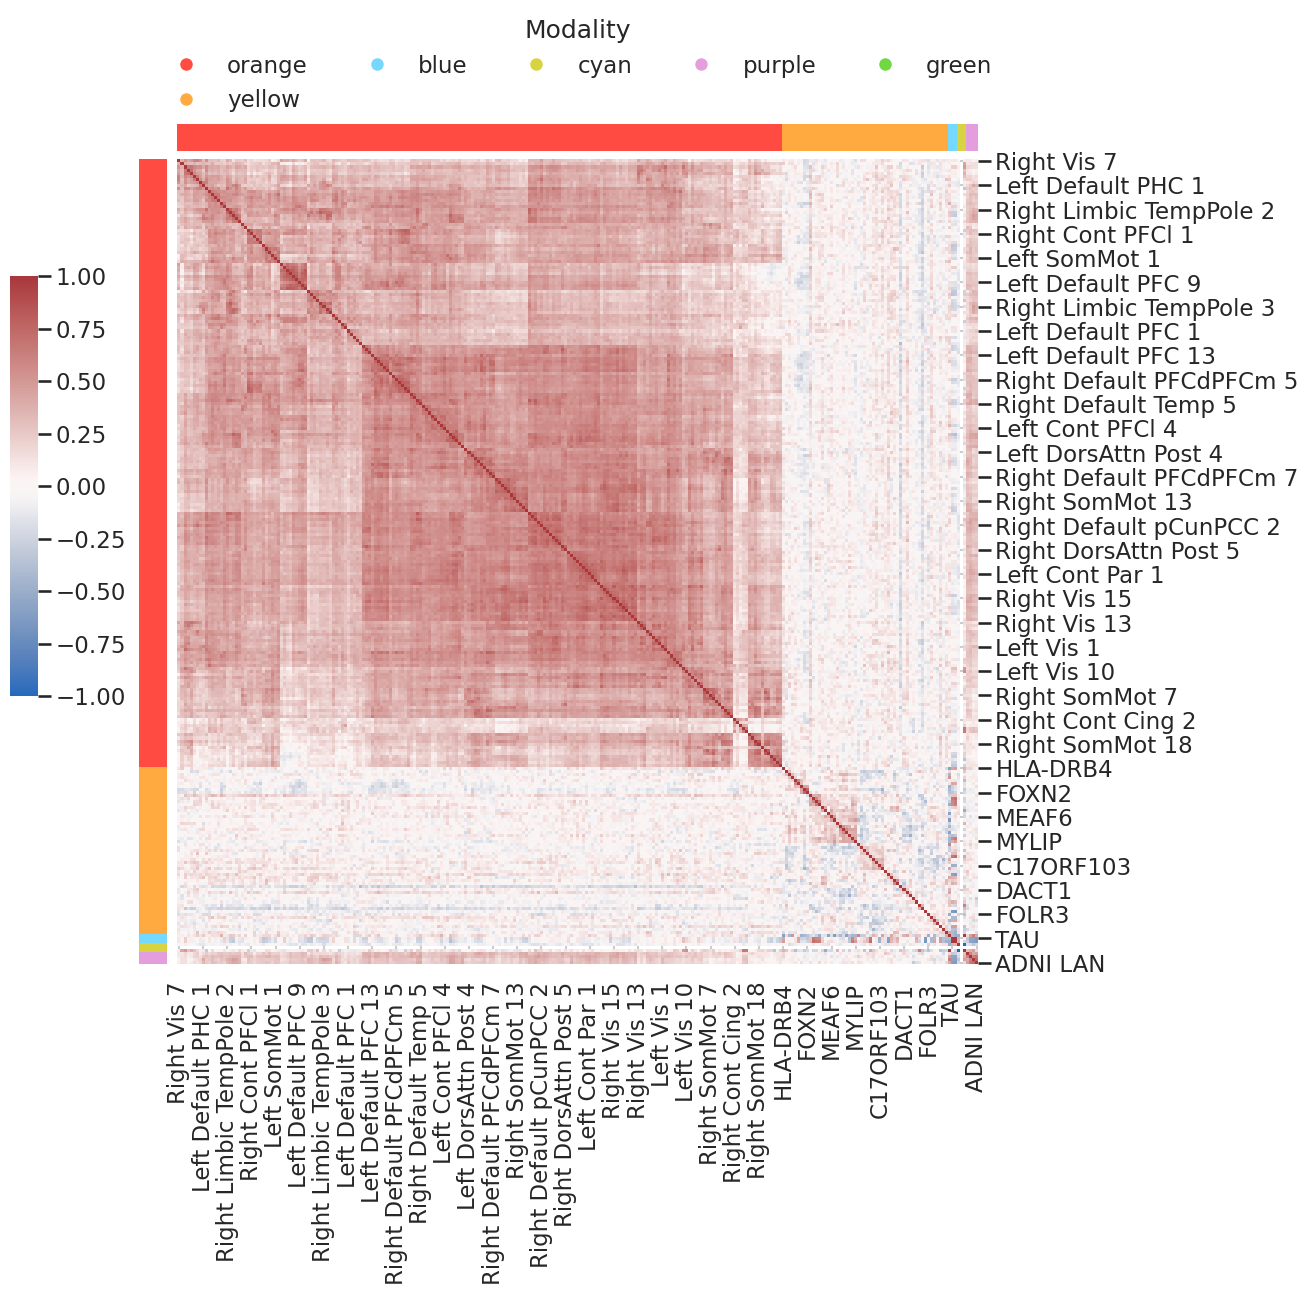

In [25]:
idx_dupl = df_all.duplicated(subset=["RID"])

df_X = df_X[miss_mask]
df_y = df_y[miss_mask]

df_feat = pd.concat([df_X[~idx_dupl], df_y[~idx_dupl]], axis=1)

# Create an empty list to store the keys
keys_list = []

# Iterate over the columns of the DataFrame
for col in df_feat.columns:
    for key, values in select.items():
        if col in values:
            keys_list.append(key)
            break

id_list = np.arange(0, len(keys_list))
new_id_list = []
new_key_list = []
cat_palette = {}
for i, mod in enumerate(["MRIth", "RNA", "CSF", "DNA", "ADNI_cog"]): 
    is_modal = [i == mod for i in keys_list]
    new_id_list.extend(id_list[is_modal])
    new_key_list.extend(np.array(keys_list)[is_modal])
    cat_palette[mod] = list(full_palette.values())[i]
row_colors = pd.Series(new_key_list).map(cat_palette)

df_corr = df_feat.iloc[new_id_list, new_id_list].corr()

# Perform subcategory-specific clustering
ordered_indices = []
for subcategory in ["MRIth", "RNA", "CSF", "DNA", "ADNI_cog"]:
    # Identify rows/columns belonging to the subcategory
    subcategory_mask = [key == subcategory for key in new_key_list]
    subcategory_indices = np.where(subcategory_mask)[0]
    
    if len(subcategory_indices) > 1:  # Ensure there are enough entries to cluster
        subcategory_data = df_corr.iloc[subcategory_indices, subcategory_indices]
        subcategory_data = subcategory_data.fillna(0) 
        
        # Compute distance matrix and linkage
        dist_matrix = pdist(subcategory_data, metric="euclidean")
        linkage_matrix = linkage(dist_matrix, method="average")
        
        # Get the order of leaves
        subcategory_order = [subcategory_indices[i] for i in leaves_list(linkage_matrix)]
        ordered_indices.extend(subcategory_order)
    else:
        ordered_indices.extend(subcategory_indices)  # Add single entries as-is

# Reorder the correlation matrix and row_colors
df_corr_reordered = df_corr.iloc[ordered_indices, ordered_indices]
row_colors_reordered = pd.Series(np.array(new_key_list)[ordered_indices]).map(cat_palette)

# Plot the updated clustermap
g = sns.clustermap(
    df_corr_reordered,
    figsize=(14, 14),
    dendrogram_ratio=0.1,
    row_colors=row_colors_reordered.values,
    col_colors=row_colors_reordered.values,
    method="centroid",
    row_cluster=False,
    col_cluster=False,
    cmap="vlag",
    vmin=-1,
    vmax=1,
    cbar_pos=(0, 0.5, 0.02, 0.3),
)

g.ax_row_dendrogram.set_visible(False) #suppress row dendrogram
g.ax_col_dendrogram.set_visible(False) 

ytick_labels = [tick.get_text() for tick in g.ax_heatmap.get_yticklabels()]
xtick_labels = [tick.get_text() for tick in g.ax_heatmap.get_xticklabels()]

def replace_ax_ticks(axtick_labels): 
    # Update tick labels
    new_labels = [clean_ytick_label(label) for label in axtick_labels]
    label_dict = {
        "ADNIMEM": "Memory",
        "ADNI EF": "Executive \n Function",  # Added \n for the line break
        "ADNI VS": "Visuospatial",
        "ADNI LAN": "Language"
    }
    for key, value in label_dict.items():
        for i in new_labels:
            i = i.replace(key, value)

    return new_labels

g.ax_heatmap.set_yticklabels(replace_ax_ticks(ytick_labels))
g.ax_heatmap.set_xticklabels(replace_ax_ticks(xtick_labels))

# Add a custom legend for group_colors at the top
handles, labels = [], []
for label, color in full_palette.items():
    handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10))
    labels.append(label.replace('MRIth', 'MRI').replace('ADNI_cog', 'Cognitive Domain Score'))

# Position the legend at the top, horizontally
g.ax_heatmap.legend(handles, labels, title="Modality", loc="upper center", bbox_to_anchor=(0.5, 1.2), ncol=5, frameon=False)

# Save the updated plot
plt.savefig("../figures/heatmap_subcategory_clustering_not_duplicated.png", format="png", bbox_inches="tight", dpi=300)


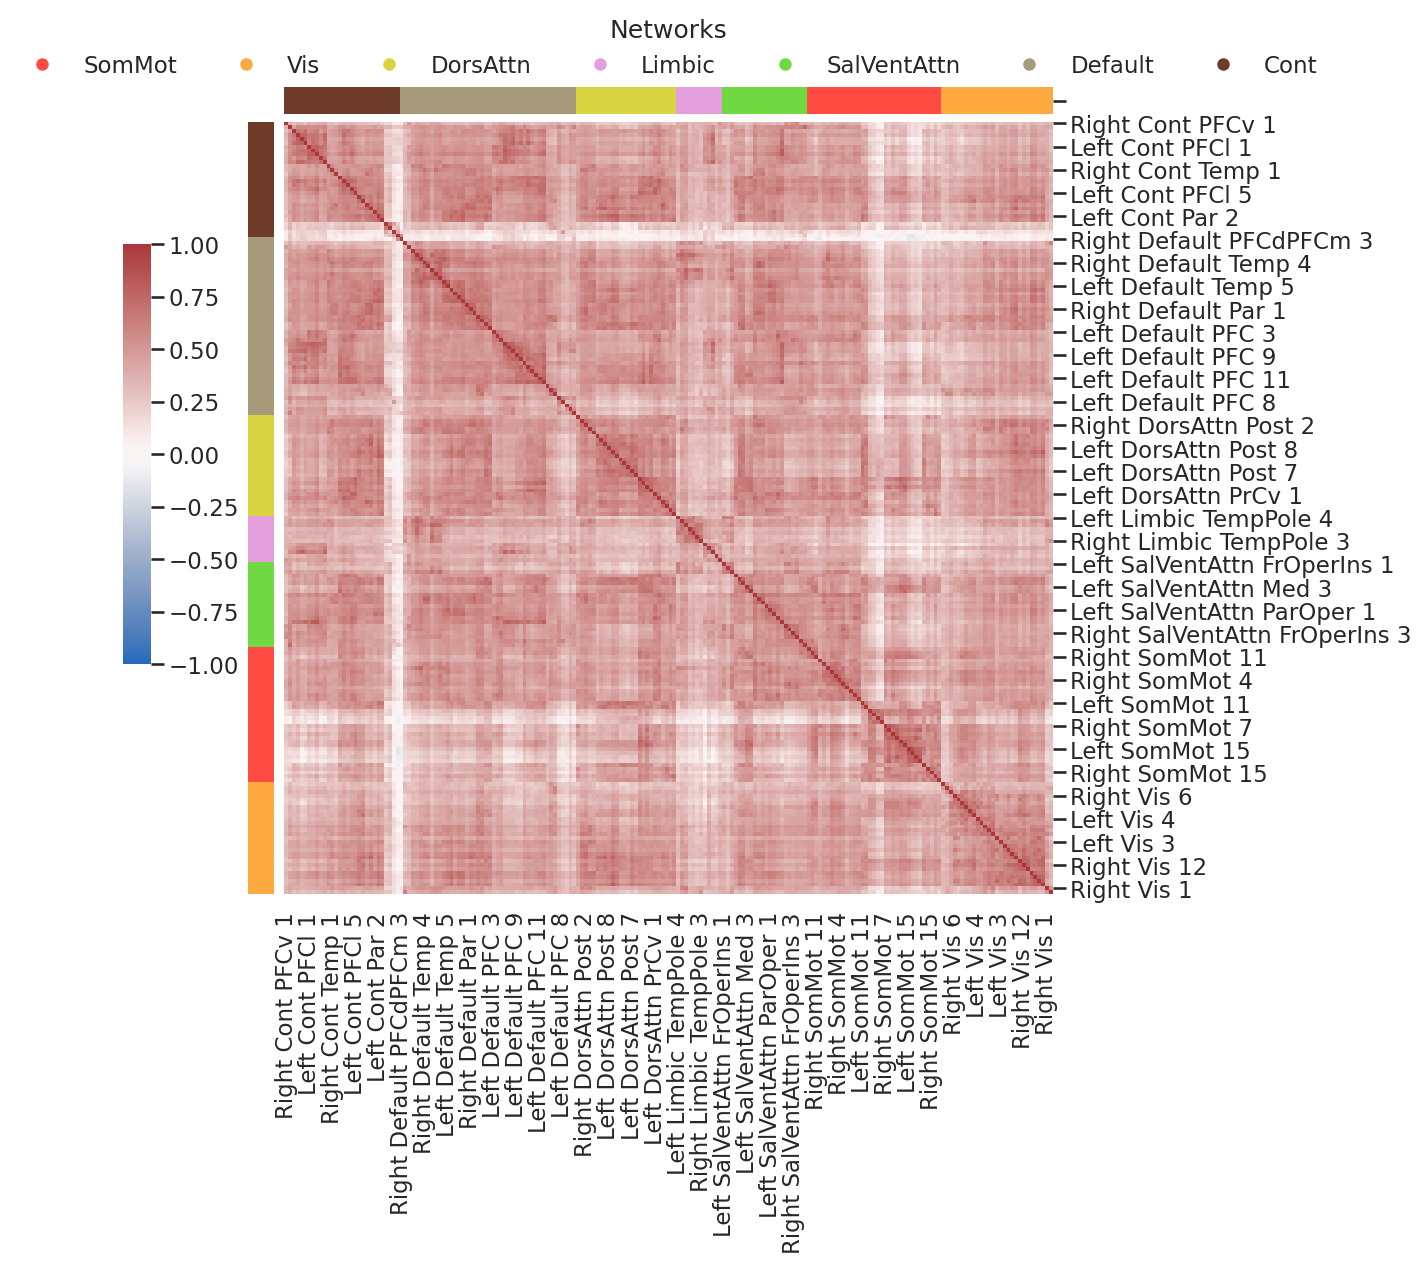

In [26]:
net_palette = {'SomMot': full_palette["orange"],
 'Vis': full_palette["yellow"],
 'DorsAttn': full_palette["cyan"],
 'Limbic': full_palette["purple"],
 'SalVentAttn': full_palette["green"],
 'Default': "#a69a7b",
 'Cont': "#6e3b29"}

lst_network = [x.split('_')[1] for x in df_X[select["MRIth"]]]

row_colors = pd.Series(lst_network).map(net_palette)

df_corr = df_X[select["MRIth"]].corr()

ordered_features = []

# Perform hierarchical clustering within each network
for network in np.unique(lst_network):
    # Get features belonging to the current network
    network_features = [feature for feature, net in zip(df_corr.columns, lst_network) if net == network]

    # Subset the correlation matrix for the network
    network_corr = df_corr.loc[network_features, network_features]

    # Convert correlation to distance
    distance = 1 - network_corr

    # Perform hierarchical clustering
    linkage_matrix = linkage(squareform(distance), method='average')
    network_order = np.array(network_features)[leaves_list(linkage_matrix)]

    # Append ordered features
    ordered_features.extend(network_order)

# Reorder the correlation matrix
ordered_corr = df_corr.loc[ordered_features, ordered_features]

g = sns.clustermap(ordered_corr, figsize=(14,14), dendrogram_ratio=0.1, 
            row_colors=pd.Series(lst_network, index=df_corr.index).map(net_palette),
            col_colors=pd.Series(lst_network, index=df_corr.index).map(net_palette),
            row_cluster=False,
            col_cluster=False,
            method="centroid", 
            cmap="vlag", vmin=-1, vmax=1,
            cbar_pos=(0, 0.5, 0.02, .3))

g.ax_row_dendrogram.set_visible(False) #suppress row dendrogram
g.ax_col_dendrogram.set_visible(False) 

ytick_labels = [tick.get_text() for tick in g.ax_heatmap.get_yticklabels()]
xtick_labels = [tick.get_text() for tick in g.ax_heatmap.get_xticklabels()]

def replace_ax_ticks(axtick_labels): 
    # Update tick labels
    new_labels = [clean_ytick_label(label) for label in axtick_labels]
    label_dict = {
        "ADNI MEM": "Memory",
        "ADNI EF": "Executive \n Function",  # Added \n for the line break
        "ADNI VS": "Visuospatial",
        "ADNI LAN": "Language"
    }
    for key, value in label_dict.items():
        for i in new_labels:
            i = i.replace(key, value)

    return new_labels

#ax.set_yticklabels([new_labels.replace('_', ' + ').replace  for label in ax.get_yticklabels()])

g.ax_heatmap.set_yticklabels(replace_ax_ticks(ytick_labels))
g.ax_heatmap.set_xticklabels(replace_ax_ticks(xtick_labels))

# Add a custom legend for group_colors at the top
handles, labels = [], []
for label, color in net_palette.items():
    handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10))
    labels.append(label.replace('MRIth', 'MRI').replace( 'ADNI_cog', 'Cognitive Domain Score'))

# Position the legend at the top, horizontally
g.ax_heatmap.legend(handles, labels, title="Networks", loc="upper center", bbox_to_anchor=(0.5, 1.16), ncol=7, frameon=False)